# TACE procedure methodology walkthrough
---

This notebook demonstrates the end-to-end workflow for training a model that can reconstruct vessel enhanced DRR images from raw DRR images making use of the 3D spatial information extracted from medical CT volumes of the corresponding patient.

## 1. Importing libraries
This pipeline is mainly based on Pytorch and its medical imaging extension MONAI for data processing and model training and DiffDRR for DRR generation. Additionally, custom functionality is imported.

In [1]:
# Import libraries
import sys

sys.path.append("..")

from src.preprocessing import get_transforms, get_datasets, get_dataloaders, add_vessel_contrast
#from src.config import config
from src.drr import create_drr

import torch
import matplotlib.pyplot as plt
from diffdrr.visualization import plot_drr, plot_mask

from diffdrr.drr import DRR
from diffdrr.data import read

from diffdrr.pose import convert

from src.model import TACEnet
from monai.losses import DiceCELoss

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 2. Data preprocessing
In this pipeline we make use of HCC-TACE-Seg dataset. This retrospectively acquired data collection includes pre- and post-procedure CT imaging studies of 105 confirmed HCC patients who underwent TACE between 2002 and 2012 with an available treatment outcome, in the form of time-to-progression and overall survival. Baseline imaging includes multiphasic contrast-enhanced CT with no image artifacts (e.g. surgical clip) and was obtained 1-12 weeks (average 3 weeks) prior to the first TACE session. Semiautomatic segmentation of liver, tumor, and blood vessels created using AMIRA was manually clinically curated. These segmentations of each pre-procedural CT study were done for the purpose of algorithm training for prediction and automatic liver tumor segmentation, and are provided here (NIfTI converted to DICOM-SEG format).

The volumes and segmnetations have the following shapes when loaded from a batch:

- volume: (1, 1, 512, 512, D) -> (B, C, H, W, D) where the depth (D) is variable
- segmentation (1, 5, 512, 512, D) -> (B, C, H, W, D) where the depth (D) is variable and correpsonds to volume


The following tranformations are then performed:
1. Load volume and segmentation to MONAI meta tensor.
2. Ensure the channel dimension is placed before the spatial dimensions
3. Resize the volume and segmnetation to a new desired dimension, using padding and cropping (optional).
4. Isolate the vessel channel of the multi class segmentation mask. This essentially turns the task in a binary segmentation problem where the segmentation will have a shape equal to the volume: (1, 1, 512, 512, D).

In [2]:
# Get transforms
transform = get_transforms(resize_shape= [512, 512, 96],contrast_value=1000)

# Get datasets
train_ds, val_ds = get_datasets(
    root_dir="../data",
    collection="HCC-TACE-Seg",
    transform=transform,
    download=False,
    val_frac=0.2,
    download_len=2
)

# Get dataloaders
train_loader, val_loader = get_dataloaders(train_ds, val_ds, batch_size=1)

# Check length of datasets and dataloaders to make sure data split is correct
print(train_ds.get_indices(), val_ds.get_indices())
print(len(train_loader), len(val_loader))

[2 1 3 0 5 4] [6]
6 1


In [3]:
# Sample a batch of data from the dataloader
batch = next(iter(train_loader))

# Separate the image and segmentation from the batch
image, seg = batch["image"], batch["seg"]

print(image.shape, seg.shape)

torch.Size([1, 1, 512, 512, 96]) torch.Size([1, 1, 512, 512, 96])


From these volumes and segmentation we can take a slice and visualize the slice to evaulate the inputs

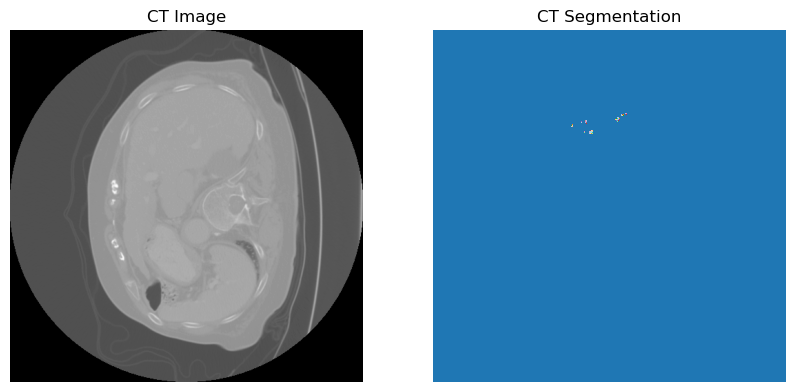

In [4]:
slice_idx = 30

# Sample a slice from the image
CT_slice = image[0, 0, :, :, slice_idx].cpu()

# Get the maximum segmentation class for each pixel in the slice
CT_seg_slice = seg[0, 0, :, :, slice_idx].cpu()

# Plot the image and segmentation slice as a subplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(CT_slice, cmap="gray")
ax[0].set_title("CT Image")
ax[0].axis("off")
ax[1].imshow(CT_seg_slice, cmap="tab20")
ax[1].set_title("CT Segmentation")
ax[1].axis("off")
plt.show()

## 3. Creating DRR images
DRR images are essentially simulated X-ray images reconsturcted by raytracing through a given 3D CT volume. The DiffDRR package comes with most of the functionality needed out-of-the-box. We will demonstrate below how to create DRR images and control output rotation, zoom and more. Currently, this does not works vectorized over a batch. 

In [5]:
# Extract first image and segmentation from the batch
img = image[0]
seg = seg[0]

# Read in CT volume and label map into a subject object
subject = read(
    tensor=img,
    label_tensor=seg,
    orientation="AP",
    bone_attenuation_multiplier=5,
)

# Create a DRR object, this will project the CT to the DRR
drr = DRR(
    subject,  # A torchio.Subject object storing the CT volume, origin, and voxel spacing
    sdd=1020,  # Source-to-detector distance (i.e., the C-arm's focal length)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    width=200,  # Width of the DRR
    delx=2.0,  # Pixel spacing (in mm)
    dely=2.0,  # Pixel spacing (in mm)
    x0=0,  # # Principal point X-offset
    y0=0,  # Principal point Y-offset
    p_subsample=None,  # Proportion of pixels to randomly subsample
    reshape=True,  # Return DRR with shape (b, 1, h, w)
    reverse_x_axis=True,  # If True, obey radiologic convention (e.g., heart on right)
    patch_size=None,  # Render patches of the DRR in series
    renderer="siddon",  # Rendering backend, either "siddon" or "trilinear"
).to(device)

# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
zero = torch.tensor([[0.0, 0.0, 0.0]], device=device)
translations = torch.tensor([[0.0, 800.0, 0.0]], device=device)

# Define the camera pose with rotations and translations in degrees, later converted to radians
rotations = torch.tensor([[0.0, 0.0, 0.0]], device=device)
rotations = torch.deg2rad(rotations)

# Convert the rotations and translations to a pose matrix
pose1 = convert(zero, translations, parameterization="euler_angles", convention="ZXY")
pose2 = convert(rotations, zero, parameterization="euler_angles", convention="ZXY")
pose = pose1.compose(pose2)

# Generate the DRR
drr_image_raw = drr(pose, mask_to_channels=True)

For our task we would need to also simulate DRR images with an enhanced vessel network corresponding to the same CT volume. Since DRR images are directly created from a CT volume the enhancement needs to be applied to the CT itself first

In [6]:
# Enhance the vessel contrast in the CT using the segmentation
img_enhanced = add_vessel_contrast(img, seg, contrast_value=1000)

# Read in CT volume and label map into a subject object
subject_enhanced = read(
    tensor=img_enhanced,
    label_tensor=seg,
    orientation="AP",
    bone_attenuation_multiplier=5,
)

# Create a DRR object, this will project the CT to the DRR
drr_enhanced = DRR(
    subject_enhanced,  # A torchio.Subject object storing the CT volume, origin, and voxel spacing
    sdd=1020,  # Source-to-detector distance (i.e., the C-arm's focal length)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    width=200,  # Width of the DRR
    delx=2.0,  # Pixel spacing (in mm)
    dely=2.0,  # Pixel spacing (in mm)
    x0=0,  # # Principal point X-offset
    y0=0,  # Principal point Y-offset
    p_subsample=None,  # Proportion of pixels to randomly subsample
    reshape=True,  # Return DRR with shape (b, 1, h, w)
    reverse_x_axis=True,  # If True, obey radiologic convention (e.g., heart on right)
    patch_size=None,  # Render patches of the DRR in series
    renderer="siddon",  # Rendering backend, either "siddon" or "trilinear"
).to(device)

# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
zero = torch.tensor([[0.0, 0.0, 0.0]], device=device)
translations = torch.tensor([[0.0, 800.0, 0.0]], device=device)

# Define the camera pose with rotations and translations in degrees, later converted to radians
rotations = torch.tensor([[0.0, 0.0, 0.0]], device=device)
rotations = torch.deg2rad(rotations)

# Convert the rotations and translations to a pose matrix
pose1 = convert(zero, translations, parameterization="euler_angles", convention="ZXY")
pose2 = convert(rotations, zero, parameterization="euler_angles", convention="ZXY")
pose = pose1.compose(pose2)

# Generate the DRR
drr_image_enhanced = drr_enhanced(pose, mask_to_channels=True)

The implementation of the DRR generation allows us to visualize both the entire image and only certain structures of interest, in this case the vessels. We can now visualize the raw DRR, the vessels only and the enhanced DRR. Note that the output of the DRR has the following shape:

$$(B, C, H, W) -> (1, 2, 200, 200)$$

Where the B does not correspond to the dataloaders batch, but the number of different poses that are provided. This means that, although DRR image generation currently only works with 1 volume segmentation pair at once, per volume multiple DRR orientations can be created in parallel. Since we are interested in changing the angle this makes it perfectly sufficient to only uses batches of size 1 and create multiple DRR images for training per batch iteration.

C is the number of channels per generated DRR (this by setting `mask_to_channel = True`) and allows for conditional rendering of different structures. Summing over the channel dimension will give the expected image. Note that the `plot_drr` function takes in a shape of (B, C, H, W), which explains the added logic below.

[<Axes: xlabel='Vessel Overlay'>]

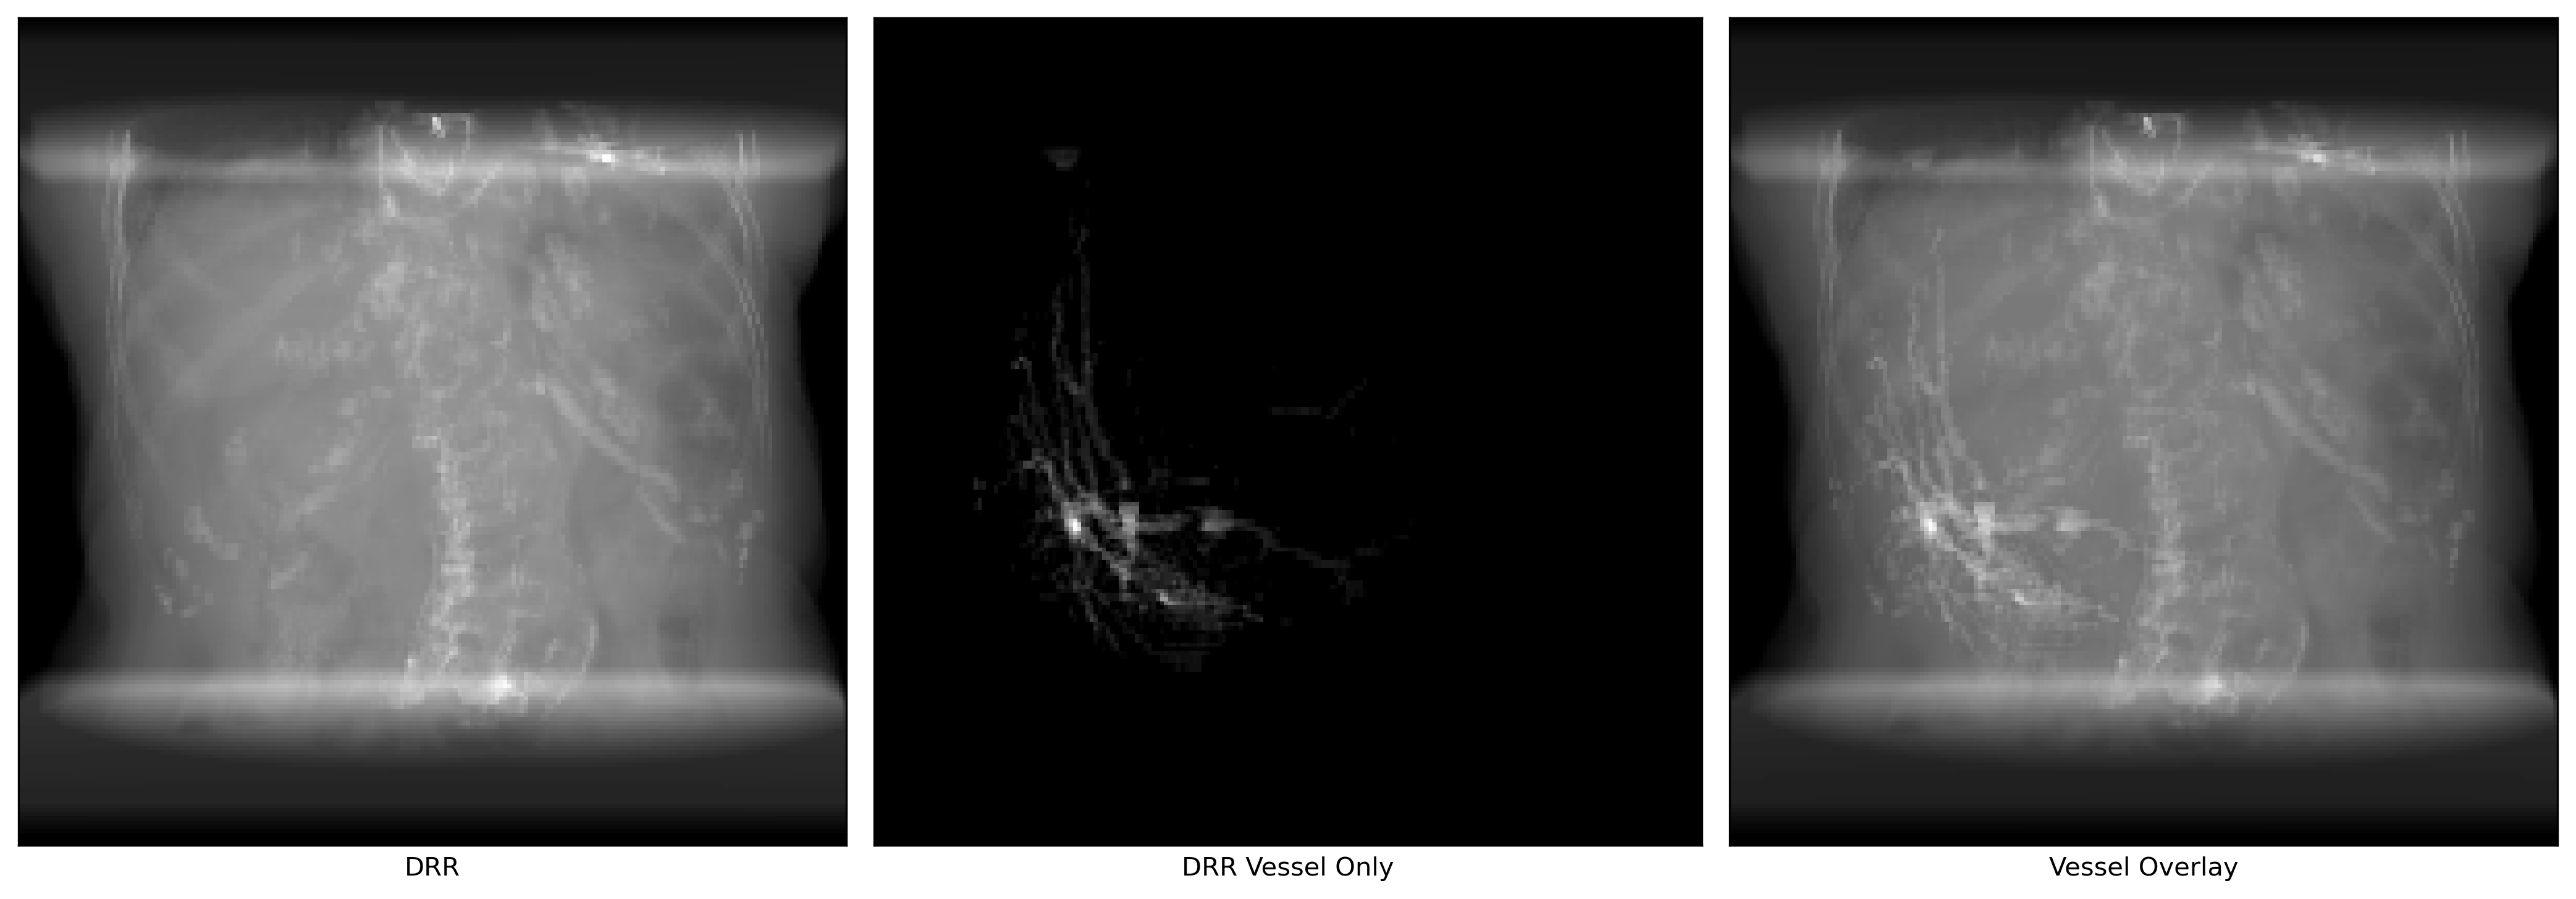

In [7]:
# Plot the segmentation masks
fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(14, 7.75),
    tight_layout=True,
    dpi=300,
)

# Plot the DRR, DRR with vessel contrast, and the enhanced DRR
plot_drr(drr_image_raw.sum(dim=1, keepdim=True), axs=axs[0], ticks=False, title="DRR")
plot_drr(
    drr_image_enhanced[:, 1, :, :].unsqueeze(dim=1),
    axs=axs[1],
    ticks=False,
    title="DRR Vessel Only",
)
plot_drr(
    drr_image_enhanced.sum(dim=1, keepdim=True),
    axs=axs[2],
    ticks=False,
    title="Vessel Overlay",
)

## 4. Model definition
The model used for this task, consists of 2 parts:
1. 3D CT volume embedding module: This part takes in a CT volume and embeds it to a 2D plane essentially compressing all 3D information in a 2D projection.
2. The second part uses this CT embedding in combination with a rawm unenhanced X-ray (DRR) image to reconstruct a vessel enhanced DRR image that can be usefull for a surgeon during image guided TACE procedures.

IMAGE OF FINAL MODEL STRUCTURE 

In [8]:
# Define model
model = TACEnet()

# Move model to device
model.to(device)

# Initialize the criterion, DICE loss with cross entropy uses binary cross entropy when there are only two classes
criterion = torch.nn.L1Loss()

# Initialize the optimizer, use config to set hyperparameters
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-2,
    weight_decay=1e-5,
)

## 5. Model Training
The training of the model is not as straight forward as compared to simple feedforward networks for classification. We need to execute the following steps for each image in a given batch:

1. Use the raw 3D CT volume to create the unenhanced DRR image.
2. Add vessel enhancement to the CT volume making use of the corresponding vessel segmentation map.
3. Use the enhanced 3D CT volume to create the vessel enhanced DRR image.
4. Embed the CT volume in latent space using the models encoder part

Then in terms of bayesian notation the problem boils down to the following where the exact model architecture is arbitrary:

$$p(DRR_e | DRR_r, CT_{embed})$$

with for clarity:
- $DRR_e$ = The vessel enhanced DRR image
- $DRR_r$ = The raw DRR image
- $CT_{embed}$ = The CT latent embedding

This expression can be read as "the probability of $DRR_e$  given $DRR_r$ and $CT_{embed}$.

We are trying to model the probability distribution of a vessel enhanced DRR image given a raw DRR image and a CT latent embedding. This is a bayesian interference task, where we are trying to infer the vessel enhanced DRR image from the raw DRR image and the CT latent embedding 3D spatial data.

At a high level, the task can be explained as a conditional image impainting or object recovery task. You might be familiar with text-based image impainting, where a model is prompted with text to change an image accordingly. This works by embedding the text prompt in latent space, to stir the image impainting/generation. In this case, the text prompt is replaced with a CT latent embedding, which guides the transformation of the image or helps in recovering the vessel object.


In [14]:
for i, inputs in enumerate(train_loader):
    if i == 0:

        # TODO: Currently only works properly with CPU due to DRR function

        # Split the inputs into volumes and targets
        volumes, targets = inputs["image"], inputs["seg"]

        print(f"Input volume and target shape: {volumes.shape, targets.shape}")

        # Create raw DRR
        drr_raw = create_drr(
        volumes[0],
        targets[0],
        bone_attenuation_multiplier=5.0,
        sdd=1020,
        height=256,
        width=256,
        rotations=torch.tensor([[0.0, 0.0, 0.0]]),
        translations=torch.tensor([[0.0, 850.0, 0.0]]),
        mask_to_channels=False,
        device="cpu",
        )

        # Raw DRR still has a channel dimension: (1, 1, 200, 200), but this does not matter for plotting the image at least
        print(f"Raw DRR shape: {drr_raw.shape}")

        # Vessel enhance the CT volumes
        volumes_enhanced = add_vessel_contrast(volumes, targets, contrast_value=1000)

        print(f"Enhanced volume shape: {volumes_enhanced.shape}")

        # Create enhanced DRR
        drr_enhanced = create_drr(
            volumes_enhanced[0],
            targets[0],
            bone_attenuation_multiplier=5.0,
            sdd=1020,
            height=256,
            width=256,
            rotations=torch.tensor([[0.0, 0.0, 0.0]]),
            translations=torch.tensor([[0.0, 850.0, 0.0]]),
            mask_to_channels=False,
            device="cpu",
        )
        
        # Check if the shape is still correct
        print(f"Enhanced DRR shape: {drr_enhanced.shape}")
        
        # # Predict the enhanced DRR using the model with the vessel mask and raw DRR
        # prediction = model(targets.to(device), drr_raw.to(device))

        # print(f"Prediction shape: {prediction.shape}")
        
        # loss = criterion(prediction, drr_enhanced.to(device))

        # print(f"Loss: {loss.item()}")
        # plt.imshow(prediction.cpu().detach().numpy().squeeze(), cmap = 'gray')
        # plt.show()
        # plt.imshow(drr_enhanced.squeeze(), cmap = 'gray')
        # plt.show()

        # loss.backward()
        # optimizer.step()
        # optimizer.zero_grad()

Input volume and target shape: (torch.Size([1, 1, 512, 512, 96]), torch.Size([1, 1, 512, 512, 96]))
Raw DRR shape: torch.Size([1, 1, 256, 256])
Enhanced volume shape: torch.Size([1, 1, 512, 512, 96])
Enhanced DRR shape: torch.Size([1, 1, 256, 256])


[<Axes: xlabel='Target'>]

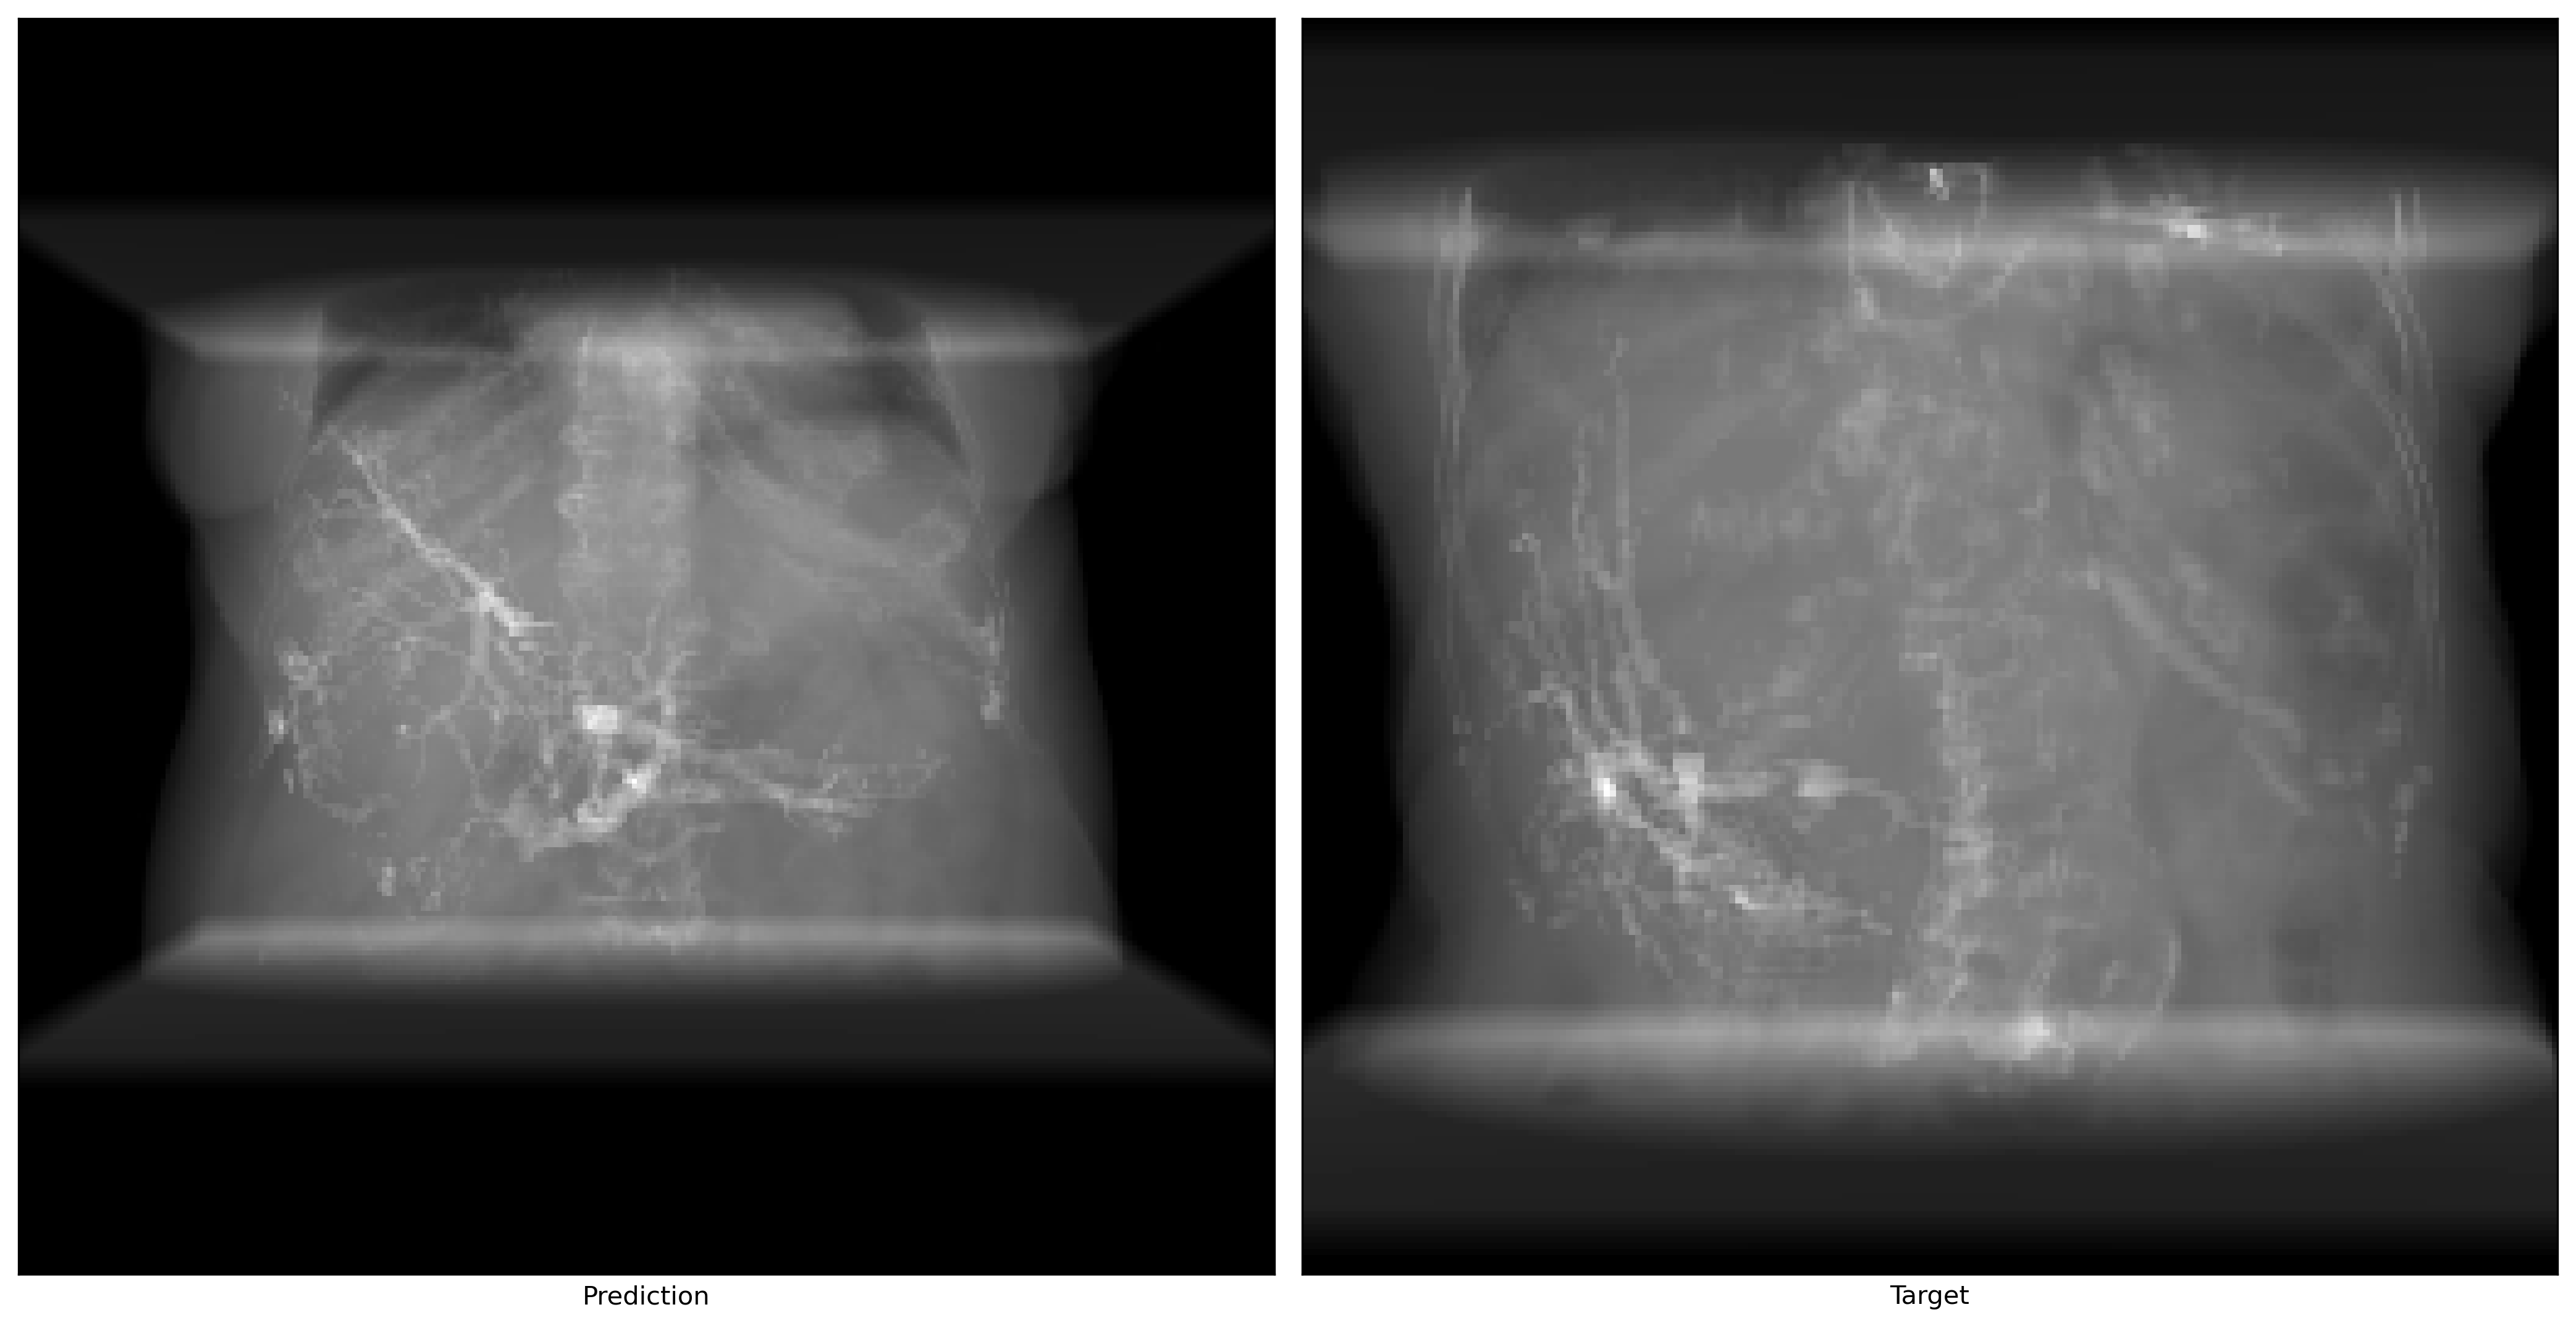

In [15]:
# Plot the segmentation masks
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(14, 7.75),
    tight_layout=True,
    dpi=300,
)

# Plot the DRR, DRR with vessel contrast, and the enhanced DRR
plot_drr(drr_enhanced, axs=axs[0], ticks=False, title="Prediction")
plot_drr(
    drr_image_enhanced.sum(dim=1, keepdim=True),
    axs=axs[1],
    ticks=False,
    title="Target",
)

In [11]:
prediction.shape

NameError: name 'prediction' is not defined